In [3]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, MultiPolygon, Polygon
from shapely.ops import unary_union, split, linemerge
import pandas as pd


In [19]:
# Carregar o arquivo grid.parquet
grid_gdf = gpd.read_parquet("inputs/grid.parquet")
n_grid=18
# Selecionar o polígono com grid_id = 22
unidade_split = grid_gdf[grid_gdf["grid_id"] == n_grid].geometry.values[0]  # Pega a geometria do grid_id 22

# Verifique se o polígono foi carregado corretamente
grid_gdf



,grid_id,geom
0,1,"POLYGON ((-40.4 -3.4, -40.4 -3.3, -40.3 -3.3, ..."
1,2,"POLYGON ((-40.4 -3.3, -40.4 -3.2, -40.3 -3.2, ..."
2,3,"POLYGON ((-40.4 -3.2, -40.4 -3.1, -40.3 -3.1, ..."
3,4,"POLYGON ((-40.4 -3.1, -40.4 -3, -40.3 -3, -40...."
4,5,"POLYGON ((-40.4 -3, -40.4 -2.9, -40.3 -2.9, -4..."
5,6,"POLYGON ((-40.4 -2.9, -40.4 -2.8, -40.3 -2.8, ..."
6,7,"POLYGON ((-40.3 -3.4, -40.3 -3.3, -40.2 -3.3, ..."
7,8,"POLYGON ((-40.3 -3.3, -40.3 -3.2, -40.2 -3.2, ..."
8,9,"POLYGON ((-40.3 -3.2, -40.3 -3.1, -40.2 -3.1, ..."
9,10,"POLYGON ((-40.3 -3.1, -40.3 -3, -40.2 -3, -40...."


In [21]:
# Definir o caminho do arquivo de entrada (Parquet) e os arquivos de saída
input_parquet = "inputs/input.parquet"        # Arquivo com os dados de entrada
output_geojson = "inputs/output_split.geojson"  # Caminho para o GeoJSON de saída
output_parquet = "inputs/output_split.parquet"  # Caminho para o Parquet de saída


In [22]:
gdf_input = gpd.read_parquet(input_parquet)
gdf_input

,id,id_layer,geom
0,728026,CAR,"MULTIPOLYGON (((-40.02239 -2.89978, -40.01137 ..."
1,745240,CAR,"MULTIPOLYGON (((-40.06323 -2.94536, -40.06242 ..."
2,745275,CAR,"MULTIPOLYGON (((-40.22094 -2.81891, -40.21935 ..."
3,745993,CAR,"MULTIPOLYGON (((-40.01066 -2.90721, -40.01087 ..."
4,746042,CAR,"MULTIPOLYGON (((-40.32682 -2.82705, -40.32739 ..."
...,...,...,...
3239,722724,CAR,"MULTIPOLYGON (((-40.01979 -3.1901, -40.01912 -..."
3240,722737,CAR,"MULTIPOLYGON (((-40.19464 -2.85399, -40.19513 ..."
3241,722770,CAR,"MULTIPOLYGON (((-40.27608 -2.8706, -40.27529 -..."
3242,725535,CAR,"MULTIPOLYGON (((-40.0133 -2.88233, -40.0089 -2..."


In [56]:
 # Verificar interseção e selecionar geometrias que tocam unidade_split
gdf_intersects = gdf_input[gdf_input.intersects(unidade_split)].reset_index(drop=True)
gdf_intersects.iloc[208]


id                                                     947881
id_layer                                                  CAR
geom        MULTIPOLYGON (((-40.09883165 -2.86679262, -40....
Name: 208, dtype: object

In [84]:
    # Explode as geometrias em `self.gdf_input_intersection` para separar MultiLineString em LineStrings
    exploded_gdf = gdf_intersects.explode(index_parts=False)

    # Criar linhas a partir dos limites dessas geometrias e mesclá-las
    lines = [linemerge(geom.boundary) for geom in exploded_gdf.geometry]

    # Combinação de pontos em uma única linha após o explode
    combined_points = [coord for line in lines for coord in line.coords]
    
    # Cria uma única geometria de LineString com todos os pontos combinados
    forced_line = LineString(combined_points)
    


/home/pedro/Documents/GIT_WORKSPACE/split_offdb/_split_offdb/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [25]:

combined_points = []
for line in list(lines_gdf.geometry):
    combined_points.extend(list(line.coords))

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

In [10]:
combined_points
forced_line = LineString(combined_points)
forced_line.geom_type

'LineString'

In [11]:
broken_glass = split(unidade_split, forced_line)

In [12]:
broken_glass_polygon = MultiPolygon(broken_glass)
broken_glass_polygon.geom_type
geometries = list(broken_glass_polygon.geoms)


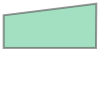

In [30]:
gdf_broken_glass = gpd.GeoDataFrame(data = {"id":range(1,len(broken_glass_polygon.geoms)+1)}, geometry=geometries, crs = 4674 )
gdf_broken_glass.geometry[0]

In [31]:
gdf_broken_glass["representative_point"] = gdf_broken_glass.geometry.apply(lambda x: x.representative_point())
gdf_broken_glass

,id,geometry,representative_point
0,1,"POLYGON ((-40.1 -3.1, -40.1 -3.0995, -40.09858...",POINT (-40.09929 -3.09975)
1,2,"POLYGON ((-40.1 -3.0995, -40.1 -3.09637, -40.0...",POINT (-40.09253 -3.08172)
2,3,"POLYGON ((-40.1 -3.09637, -40.1 -3.09065, -40....",POINT (-40.09973 -3.09325)
3,4,"POLYGON ((-40.1 -3.06524, -40.1 -3.06281, -40....",POINT (-40.08411 -3.08158)
4,5,"POLYGON ((-40.1 -3.06281, -40.1 -3.0395, -40.0...",POINT (-40.08659 -3.07083)
...,...,...,...
16340,16341,"POLYGON ((-40.03034 -3.05797, -40.03034 -3.057...",POINT (-40.03036 -3.05798)
16341,16342,"POLYGON ((-40.03037 -3.05786, -40.03034 -3.057...",POINT (-40.03038 -3.05791)
16342,16343,"POLYGON ((-40.02846 -3.05844, -40.02846 -3.058...",POINT (-40.02846 -3.05844)
16343,16344,"POLYGON ((-40.02894 -3.05833, -40.02846 -3.058...",POINT (-40.02889 -3.05852)


In [32]:
# Criar lista para armazenar informações de correlação de glass_shard com input_split
correlation_data = []


for index, shard in gdf_broken_glass.iterrows():
    glass_shard_point = shard["representative_point"]
    
    # Selecionar polígonos de input_split que sobrepõem o ponto representativo
    overlapping_polygons = gdf_input[gdf_input.contains(glass_shard_point)]
    
    # Verificar se há sobreposição
    if not overlapping_polygons.empty:
        # Extrair id_layer e id dos polígonos que sobrepõem o ponto representativo
        ids = overlapping_polygons["id"].tolist()
        id_layers = overlapping_polygons["id_layer"].tolist()
    else:
        # Caso não haja sobreposição, atribuir "void" e o id do unidade_split
        ids = [n_grid]
        id_layers = ["void"]
    
    # Adicionar ao dicionário de correlação
    correlation_data.append({
        "id": ids,
        "id_layer": id_layers
    })




correlation_data


[{'id': [22], 'id_layer': ['void']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310, 418507], 'id_layer': ['CAR', 'CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310, 463299], 'id_layer': ['CAR', 'CAR']},
 {'id': [984310, 463299], 'id_layer': ['CAR', 'CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [984310], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [805190], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [907963], 'id_layer': ['CAR']},
 {'id': [907963], 'id_layer': ['CAR']},
 {'id': [907963], 'id_layer': ['CAR']},
 {'id': [22], 'id_layer': ['void']},
 {'id': [22],

In [33]:
gdf_broken_glass.drop(columns='representative_point', inplace=True)

In [36]:
# Converter a coluna 'id' em ambos os DataFrames para string
df_correlation_data = pd.DataFrame(data=correlation_data)
df_correlation_data["id"] = df_correlation_data["id"].astype(str)
gdf_broken_glass["id"] = gdf_broken_glass["id"].astype(str)

# Realizar o merge agora que as colunas estão no mesmo tipo
gdf_merged = gdf_broken_glass.merge(df_correlation_data, on="id", how="left")


KeyError: "['overlapping_ids'] not in index"

In [ ]:
self.gdf_broken_glass["representative_point"] = self.gdf_broken_glass.geometry.apply(lambda x: x.representative_point())

correlation_data = []

for index, shard in self.gdf_broken_glass.iterrows():
    glass_shard_point = shard["representative_point"]
    overlapping_polygons = self.input_gdf[self.input_gdf.contains(glass_shard_point)]
    
    # Obtém o grid_id do objeto unidade_split
    grid_id = getattr(self.unidade_split, "grid_id", None)
    
    if not overlapping_polygons.empty:
        # Cria listas de 'id_layer' e 'id' e adiciona o grid_id como primeiro item
        id_layers = [grid_id] + overlapping_polygons["id_layer"].tolist()
        id_features = [grid_id] + overlapping_polygons["id"].tolist()
    else:
        # Para o caso vazio, adiciona o grid_id como primeiro item com valores padrão
        id_layers = [grid_id, "void"]
        id_features = [grid_id, getattr(self.unidade_split, "id", None)]
    
    # Armazena os resultados em correlation_data
    


In [ ]:
gdf_merged = gdf_merged[['id', 'overlapping_ids', 'geometry']]

# Exportar para GeoJSON
gdf_merged.to_file('split.geojson', driver="GeoJSON")

# Visualizar o resultado
gdf_merged